<a href="https://colab.research.google.com/github/NazaGara/tm_seriesTV/blob/main/tw_shows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final - Text Mining 2021
Garagiola Nazareno


### Pipeline:
---
tweets --▶      fasttext            --▶ LDA --▶ KNN
 
tweets --▶ CountVectorizer --▶ KMeans --▶ KNN --▶ KNN
       
\
---

## Getting started

In [ ]:
!python -m spacy download es_core_news_md
!pip install --upgrade pandas
!pip install pyLDAvis

In [1]:
import spacy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import random

random.seed(10)
np.random.seed(10)

In [2]:
from gensim.models import KeyedVectors

f = f"drive/MyDrive/tm_series/fasttext_spanish_twitter_100d.vec"

wordvectors = KeyedVectors.load_word2vec_format(f)

In [3]:
with open('corpus.txt', 'r') as f:
    text = f.read()
    text = text.split('\n')
    corpus = list(set(text))
len(corpus)

19717

In [4]:
with open('stopwords.txt','r') as f:
    es_stop = f.read().split('\n')

## Procesamiento

In [5]:
import spacy
nlp = spacy.load("es_core_news_md")

In [6]:
words = list()
for tw in corpus:
    for w in tw.split(' '):
        words.append(w.lower())

counter = Counter(words)

In [7]:
def filter_token(token):
    return len(token.text) < 2 or token.is_punct or token.like_url or token.is_space or token.text[0]=='@'

def convert_listwords(list_words):
    text = ""
    for word in list_words:
        text = text + " " + word
    return text

def clean_tweets(corpus=corpus):
    """
    Funcion para filtrar las palabras de los tweets luego de procesarlas con 
    Spacy.
    Devuelve un diccionario que le asigna un ID a cada tweet.
    """
    data = {}
    for position, tweet in enumerate(corpus):
        doc = nlp(tweet.strip())
        list_words = []
        for token in doc:
            if filter_token(token): continue
            list_words.append(token.text.lower())
        
        data[position] = {"tweet": convert_listwords(list_words), "vector": ''} 
    return data

def wv_clean_tweets(corpus=corpus):
    """
    Funcion similar a la de arriba, pero en este caso se usamos un embedding de
    FastText para asignarle un valor en forma de vector a cada tweet.
    Devuelve un diccionario que le asigna un ID a cada tweet.
    """
    data = {}
    for position, tweet in enumerate(corpus):
        doc = nlp(tweet)
        list_words = []
        vector_value = np.array([0 for i in range(100)], dtype=np.float64)
        for token in doc:
            if filter_token(token): continue
            if not (token.text.lower() in wordvectors.vocab): continue
            list_words.append(token.text.lower())
            vector_value += np.array(wordvectors.word_vec(token.text.lower()), dtype=np.float64)
        
        data[position] = {"tweet": convert_listwords(list_words), "vector": vector_value}
    return data

In [8]:
data = clean_tweets(corpus)
clean = [data[i]['tweet'] for i in data]

In [9]:
wv_data = wv_clean_tweets(corpus)
wv_vectors = [wv_data[i]['vector'] for i in wv_data]
wv_X = np.matrix(wv_vectors)

---
## Algoritmos

Para el proyecto utilizo los siguientes algoritmos y correspondientes implementaciones:

1. [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
1. [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html)
1. [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
1. [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
1. [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize(array, min_df):
    vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=es_stop, min_df=min_df)
    matrix = vectorizer.fit_transform(array)
    return matrix

from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

VARIANCE_THRESHOLD = 1e-7
def transform(matrix):
    selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
    normed_matrix = normalize(matrix, axis=1, norm='l1')
    reduced_matrix = selector.fit_transform(normed_matrix)
    return normed_matrix, reduced_matrix

In [12]:
#clean_X_10 = vectorize(clean, 10)
#clean_X_20 = vectorize(clean, 20)
#clean_X_30 = vectorize(clean, 30)
#clean_X_40 = vectorize(clean, 40)

clean_X = vectorize(clean, 50)
normed_X, transformed_X = transform(clean_X)

In [13]:
for pos, key in enumerate(list(data.keys())):
    data[key]['vector'] = transformed_X[pos]

In [14]:
transformed_X.shape, wv_X.shape

((19717, 377), (19717, 100))

In [15]:
from sklearn.cluster import KMeans

def sklearn_clustering(k, matrix):
    """
    Se usa la euclidea porque ya estan normalizados, y cosine normalizada 
    es parecida a euclidea.
    Retorna los labels de cada punto y una lista con las coordenadas de los 
    centroides de cada cluster.
    """
    clusterer = KMeans(n_clusters=k, random_state=10, n_init=20)
    clusterer.fit(X=matrix)
    return clusterer.labels_, clusterer.cluster_centers_

from sklearn.manifold import TSNE

def tsne_reduction(matrix):
    """
    Reduccion de dimensionalidad via T-sne para poder visualizar los datos
    """
    tsne = TSNE(n_components=2, random_state=10)
    tsne_data = tsne.fit_transform(matrix)
    return tsne_data

In [17]:
NUM_CLUSTERS = 20

clean_sk_cluster, centers =  sklearn_clustering(NUM_CLUSTERS, transformed_X)
clean_tsne_data = tsne_reduction(transformed_X)

row = [(clean_tsne_data[i], clean_sk_cluster[i], clean[i]) for i in range(len(data))]
clean_df = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in row],
    columns=["dim1", "dim2", "cluster", "tweet"]
)

# Creo que no haria falta hacer esto para los que vienen de los embeddings

# wv_cluster, centers = sklearn_clustering(20, wv_matrix)
# wv_tsne = tsne_reduction(wv_matrix)
# 
# ##Aca puedo intentar de guardar tambien algunas caracteristicas, podria seguir 
# ##reduciendo dimensionalidad, o anotar los centros de alguna forma!
# wv_row = [(wv_tsne[i], wv_cluster[i], clean[i]) for i in range(len(data))]
# wv_df = pd.DataFrame(
#     data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in wv_row],
#     columns=["dim1", "dim2", "cluster", "tweet"]
# )

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [18]:
def plot_all(df, colorbar=False):
    plt.figure(figsize=(22, 8))
    g = plt.scatter(x=df['dim1'],y=df['dim2'], s=10, c=df['cluster'], cmap='tab20', alpha=1)
    if colorbar: plt.colorbar(g)
    plt.show()

def show_cluster(df, n):
    msgs = list(df[df['cluster']==n]['tweet'])
    for msg in msgs:
        text = msg
        print(text)

def df_of_cluster(df, n):
    return df[df['cluster']==n]

from random import randint

def show_sample(df):
    for i in range(NUM_CLUSTERS):
        u = randint(0,NUM_CLUSTERS)
        msg = list(df[df['cluster']==i]['tweet'])[u]
        print(f"Cluster {i}. Sample: {msg}")

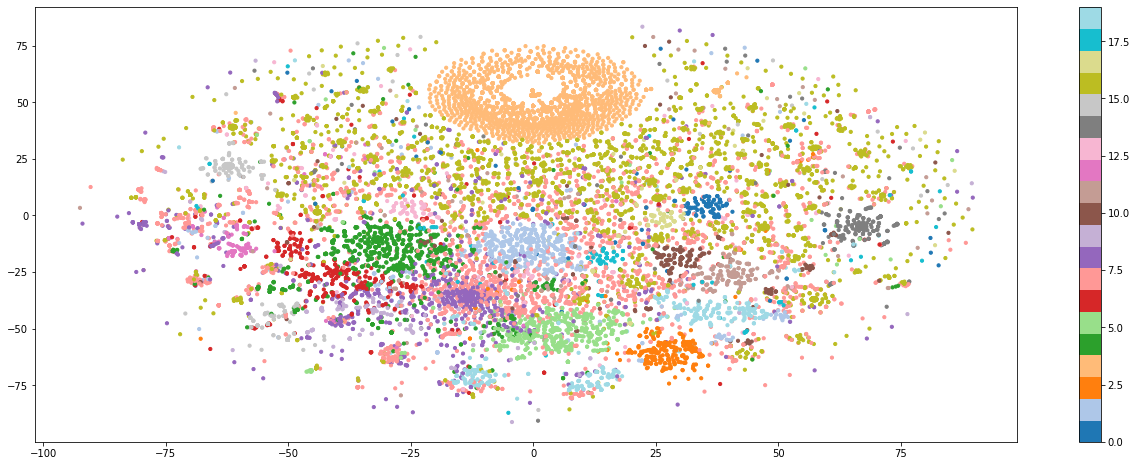

In [19]:
plot_all(clean_df, True)

In [20]:
show_sample(clean_df)

Cluster 0. Sample:  hay ninos viendo el juego del calamar
Cluster 1. Sample:  15 kilos suarez por 33 nos traemos mas de 400 koreanos del juego del calamar que al menos mueren por jugar
Cluster 2. Sample:  la casa de papel tras el juego del calamar es el mayor nivel de intensidad que estoy dispuesta sufrir este ano no mas
Cluster 3. Sample:  si tu startup fuera el juego del calamar en que juego se encuadraria tecnologia
Cluster 4. Sample:  la dirigencia politica de oposicion tiene que conseguir reunirse con el fiscal que escuche la otra cara de la moneda no quedarse parado como la serie el juego del calamar hay que presionar forzar los errores del regimen
Cluster 5. Sample:  denuncian que en un shopping de avellaneda hicieron recrear ninos el juego del calamar
Cluster 6. Sample:  el juego del calamar cuanto gano netflix que esta considerando el creador de la serie
Cluster 7. Sample:  lanzaron una criptomoneda inspirada en el juego del calamar su precio se disparo 40.000 en menos de una 

In [ ]:
show_cluster(clean_df, 19)

---

In [21]:
def export_cluster(df, k):
    new_df = df_of_cluster(df, k)
    new_df.to_pickle(f"drive/MyDrive/tm_series/clusters/allcorpus_{k}.pkl")

In [2]:
#data_file = open("drive/MyDrive/tm_series/data.pkl", "wb")
#wv_data_file = open("drive/MyDrive/tm_series/wv_data.pkl", "wb")
#pickle.dump(data, data_file)
#pickle.dump(wv_data, wv_data_file)

#f = open("drive/MyDrive/tm_series/data.pkl", "rb")
#data = pickle.load(f)
#f = open("drive/MyDrive/tm_series/wv_data.pkl", "rb")
#wv_data = pickle.load(f)

#with open('drive/MyDrive/tm_series/data.pkl', 'rb') as handle:
#    data = pickle.load(handle)
with open('drive/MyDrive/tm_series/wv_data.pkl', 'rb') as handle:
    wv_data = pickle.load(handle)


In [22]:
for i in range(NUM_CLUSTERS):
    export_cluster(clean_df, i)

---
## LDA

In [23]:
import gensim

In [24]:
import spacy
nlp = spacy.load("es_core_news_md")

In [25]:
tws = list()
for k in wv_data:
    words = []
    for w in wv_data[k]['tweet'].strip().split(' '): #nlp(wv_data[k]['tweet']):
        if w in es_stop: continue
        # if filter_token(token) or (token.text in es_stop): continue
        words.append(w)
    tws.append(words)

len(tws)

19717

In [26]:
dictionary = gensim.corpora.Dictionary(tws)
dictionary.filter_extremes(no_below=40, no_above=0.5)
bow_corpus = [dictionary.doc2bow(doc) for doc in tws]

In [27]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 14,
                                   id2word = dictionary,                                    
                                   passes = 40,
                                   workers = 4)

In [70]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.269291 -0.146402       1        1  9.693901
13    -0.107452 -0.183241       2        1  8.603974
1      0.185606 -0.182608       3        1  8.311208
9      0.111941  0.007090       4        1  7.594336
12    -0.116824  0.001523       5        1  7.431740
10     0.141930 -0.016588       6        1  7.063674
11    -0.260106 -0.074002       7        1  6.969199
2      0.141576  0.200059       8        1  6.658970
0     -0.027070  0.148312       9        1  6.611103
4     -0.086788  0.069950      10        1  6.555045
7     -0.096840  0.032726      11        1  6.416638
6     -0.045333 -0.153981      12        1  6.286959
8      0.037239  0.313448      13        1  6.165101
3     -0.147169 -0.016286      14        1  5.638153, topic_info=          Term         Freq        Total Category  logprob  loglift
17         mas  1439.000000  1439.000000  Default  30.0000  30.0000
13   halloween   859.000000   859.000000  Default  29.0000  29.0000
7        serie  2112.000000  2112.000000  Default  28.0000  28.0000
50       visto   784.000000   784.000000  Default  27.0000  27.0000
49     netflix   854.000000   854.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
8      ficcion    67.705840    80.016420  Topic14  -3.8060   2.7086
436   pusieron    56.810835    73.479068  Topic14  -3.9814   2.6183
285      acaba    61.536535    80.573721  Topic14  -3.9015   2.6061
109    persona   112.086923   157.546765  Topic14  -3.3019   2.5352
389    termine    98.756075   144.365994  Topic14  -3.4285   2.4959

[513 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
279      12  0.078318       001
279      14  0.900658       001
308       2  0.995971        10
59       13  0.976596       100
276       2  0.985047        14
...     ...       ...       ...
133       2  0.970509       wtf
69        3  0.997704        xd
337       5  0.992062      york
386      11  0.989973       you
141      13  0.988234  youtuber

[669 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 14, 2, 10, 13, 11, 12, 3, 1, 5, 8, 7, 9, 4])

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")

---
## KNN

In [43]:
#df = pd.read_pickle(f"drive/MyDrive/tm_series/clusters/corpus_11.pkl")

df = pd.read_pickle(f"drive/MyDrive/tm_series/clusters/allcorpus_19.pkl")

In [30]:
from sklearn.neighbors import KNeighborsClassifier

def sklearn_KNN(X,y):
    classifier = KNeighborsClassifier(n_neighbors=3, p=2) #p=2 ==> euclidean
    classifier.fit(X,y)
    return classifier

In [44]:
tws = list()
tws_vects = list()
for j in df.index:
    tws.append(wv_data[j]["tweet"])
    tws_vects.append(wv_data[j]["vector"])

---

Clases identificadas en cluster 11:

- cansado
- gusta
- desagrado
- desinteres

In [34]:
tws[29]  # data[544]['tweet']      #cansado
tws[26]  # data[489]['tweet']      #cansado
tws[288] # data[4989]['tweet']     #cansado
tws[262] # data[4751]['tweet']     #desagrado
tws[76]  # data[1441]['tweet']     #desagrado
tws[73]  # data[1329]['tweet']     #gusta
tws[95]  # data[1801]['tweet']     #gusta
tws[103] # data[1943]['tweet']     #gusta
tws[156] # data[3026]['tweet']     #gusta
tws[87]  # data[1645]['tweet']     #desinteres
tws[159] # data[3049]['tweet']     #desinteres

' hay que evitar el juego del calamar'

In [36]:
idx = np.array([29, 26, 288, 262, 76, 73, 95, 103, 156, 87, 159])
valoration = np.array(['cansado','cansado','cansado', 'desagrado','desagrado', 'gusta','gusta','gusta','gusta', 'desinteres','desinteres'])
labels = le.fit_transform(valoration)
feats = np.array([tws_vects[i] for i in idx])


---

In [45]:
len(tws)

680

In [ ]:
# 30, 100, 660 -> prohibicion disfraces
# 80, 120, 200, 250 -> muertos, tiroteo
# 320, 40, 290,  -> cansado disfraces
for i in range(0, len(tws), 10):
    print(f"{i}: {tws[i]}")

In [48]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [56]:
idx = np.array([30, 100, 660, 80, 120, 200, 250, 320, 40, 290])
valoration = np.array(['prohibicion_disfraz','prohibicion_disfraz','prohibicion_disfraz',
                       'muertos', 'muertos', 'muertos','muertos',
                       'cansado_disfraz','cansado_disfraz','cansado_disfraz'])
labels = le.fit_transform(valoration)
feats = np.array([tws_vects[i] for i in idx])


In [54]:
feats.shape

(10, 100)

In [ ]:
from scipy.sparse import csr_matrix
n = len(idx)
test = csr_matrix((n, transformed_X.shape[1]), dtype=np.int64)
for row in range(n):
    test[row] = feats[row]

In [57]:
KNN = KNeighborsClassifier(n_neighbors=3, p=2)
KNN.fit(feats, labels)

KNeighborsClassifier(n_neighbors=3)

Con estos tweets recopilados, la idea es poder hacer KNN con estos tweets como centros.

In [65]:
tws_vects[0].dtype

dtype('float64')

In [ ]:
prediction = KNN.predict(tws_vects[615].reshape(1,-1))
tws[615], le.inverse_transform(prediction)

In [68]:
for i in range(len(tws)):
    print(f"{tws[i]}: {le.inverse_transform(KNN.predict(tws_vects[i].reshape(1,-1)))}")

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

 podemos reiniciar el mes octubre esq no me hice casi fotos con el disfraz la del juego del calamar en halloween sabes: ['cansado_disfraz']
 squid la criptomoneda inspirada en el juego del calamar alza vuelo halloween: ['muertos']
 la inquietante transformacion de cristina pedroche en la de el juego del calamar todos los disfraces de halloween de zapeando: ['muertos']
 te gusta el juego del calamar te traemos cinco maquillajes inspirados en la serie de moda ideales para dar mucho miedo en la noche de halloween quieres verlos belleza: ['cansado_disfraz']
 ocho muertos entre un tiroteo ejecuciones en una noche de halloween sangrienta en panama cinco personas murieron en una discoteca donde imagenes de el juego del calamar otros tres cadaveres fueron hallados en un vertedero leer: ['cansado_disfraz']
 hice un dub junto unos queridos amigos manana saco por fin mi animacion del juego del calamar fandub dubs halloween videojuegos: ['cansado_disfraz']
 xq en halloween va todo el mundo de demo

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

 me pregunto si este halloween habra alguien que se haya disfrazado de algun personaje de el juego del calamar: ['cansado_disfraz']
 el juego del calamar el disfraz del ano para halloween: ['muertos']
 seguro que ninguno esperabamos que el disfraz mas usado este ano por halloween sea el del juego del calamar: ['cansado_disfraz']
 imperdibles de senora de la harina pan hasta el juego del calamar asi fueron los disfraces de los artistas venezolanos para este halloween 2021 fotos venezuela: ['cansado_disfraz']
 varias escuelas de estados unidos prohibieron los disfraces de el juego del calamar por halloween: ['muertos']
 recuento de cuanta gente me he encontrado disfrazada de el juego del calamar bueno no ha sido para tanto nos vemos el proximo halloween con la siguiente mierda que se ponga de moda: ['cansado_disfraz']
 por halloween se disparan las ventas de uniformes de el juego del calamar en corea del sur: ['muertos']
 increible cinco personas murieron en un tiroteo el viernes durante

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r


 halloween ya se acerca halloween seguramente los disfraces mas populares seran los de la serie de netflix el: ['muertos']
 video una fiesta de halloween con tematica de el juego del calamar termino en tragedia luego de que sujetos armadas en el lugar dejando muertos mientras que los cuerpos de otros tres asistentes fueron hallados en el basurero municipal: ['cansado_disfraz']
 el colmo de la locura desatada por esa serie de calamar casi muertos en panama por fiesta tematica de halloween jugando en juego del calamar: ['cansado_disfraz']
 ocho muertos en una fiesta de halloween en la que el juego del calamar: ['muertos']
 en panama hicieron una del juego del calamar por halloween real mataron personas unos unas enfermas: ['muertos']
 al parecer los disfraces que mas este 2021 en halloween es britney el juego del calamar: ['muertos']
 imperdibles de senora de la harina pan hasta el juego del calamar asi fueron los disfraces de los artistas venezolanos para este halloween 2021 fotos vene

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

 imaginense que los chicos este halloween suban un dance practice con tematica del juego del calamar uno salga de la deseos tercermundistas: ['cansado_disfraz']
 yendo ver los trajes de la gente por halloween la mayoria se viste del juego del calamar: ['muertos']
 miles de personas utilizaron sus mejores disfraces para celebrar halloween los atuendos de la serie del juego de calamar los mas utilizados: ['cansado_disfraz']
 escuelas en nueva york prohiben disfraces del el juego del calamar para halloween: ['prohibicion_disfraz']
 aiuda toi en la fiesta de halloween pusieron el remix de el juego del calamar: ['muertos']
 si fui porter tome comi gratis me diverti haciendo de ejecutor del juego del calamar por eso me pagaron halloween: ['cansado_disfraz']
 el disfraz de el juego del calamar el mas buscado en google por los colombianos para halloween: ['muertos']
 cago en todo el puto juego del calamar halloween joder: ['muertos']
 la musica de los juegos del juego del calamar casi tienen e

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

 una fiesta de halloween que la serie el juego del calamar termino en masacre noticia: ['muertos']
 la originalidad que tienen todos los que en halloween se han disfrazado de algo del juego del calamar es taaaaan impresionante en serio los mas creativos del mundo no teneis rival: ['cansado_disfraz']
 jefferson farfan se disfraza como personaje de el juego del calamar en halloween video: ['cansado_disfraz']
 horror en halloween una fiesta de el juego del calamar acaba con ocho muertos en panama via: ['muertos']
 el juego del calamar marca el primer halloween sin restricciones tras la pandemia: ['muertos']
 termine el juego del calamar entretenida pero no la volveria ver definitivamente lanzar una serie koreana con disfraces 1/2 meses antes de halloween no fue ninguna casualidad: ['cansado_disfraz']
 apuesto lo que sea que para halloween la gente va salir disfrazada del juego del calamar: ['cansado_disfraz']
 escuelas del estado de prohibieron los disfraces de el juego del calamar para h

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r